In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.cluster.hierarchy import fcluster
from scipy.stats import mode
from matplotlib.patches import Patch

In [5]:
sample_name="SPECTRUM_OV003"
experiment_id="SHAH_H000005_T03_05_DLP01"
signals_path="/data1/shahs3/isabl_data_lake/analyses/46/16/44616/results/hscn.csv.gz"
hmmcopy_path="/data1/shahs3/isabl_data_lake/analyses/45/20/44520/results/SHAH_H000005_T03_05_DLP01_hmmcopy_reads.csv.gz"

In [72]:
def long_to_cell_bin_matrix(df, select_chr = None, value_col="state"):
    """
    Converts long-format bin-level data to a matrix with cells as rows and bins as columns.

    Parameters:
    - df: DataFrame with 'chr', 'start', 'end', 'cell_id', and the value_col.
    - value_col: Column to use as matrix values (e.g., 'reads', 'state').

    Returns:
    - A pivoted DataFrame with cells as rows and bins as columns.
    """

    # Construct bin label
    if select_chr is not None:
        df = df[df['chr'].isin(select_chr)]
    df['bin_id'] = df['chr'].astype(str) + ":" + df['start'].astype(str) + "-" + df['end'].astype(str)

    # Pivot
    matrix = df.pivot(index='cell_id', columns='bin_id', values=value_col)
    matrix.columns.name = None

    # Sort columns by chr and start coordinate
    def chr_sort_key(x):
        chrom, start = x.split(":")
        try:
            chrom_val = int(chrom)
        except ValueError:
            # Map X, Y, MT to higher values for sorting
            chrom_map = {"X": 23, "Y": 24, "MT": 25}
            chrom_val = chrom_map.get(chrom.upper(), 26)
        return (chrom_val, int(start.split("-")[0]))

    sorted_cols = sorted(matrix.columns, key=chr_sort_key)
    matrix = matrix[sorted_cols]

    return matrix


state_colors = {
    "-2": "#2C78B2",  # Dark blue
    "-1": "#94C4DB",  # Light blue
    "0": "#C5C5C5",  # Gray
    "1": "#FCC484",  # Light orange
    "2": "#FA8154",  # Orange
    "3": "#DD4031",  # Red-orange
    "4": "#A9000D",  # Dark red
    "5": "#8C033A",  # Burgundy
    "6": "#6A1B9A",  # Medium purple
    "7": "#4A148C",  # Dark purple
    "8": "#38006B",  # Very dark purple
    "9": "#2E0057",  # Deep purple
    "10": "#240043",  # Almost black purple
    "11": "#1A002F",  # Darkest purple
    "12": "#12001C",  # Near-black purple
}

def plot_state_heatmap(matrix, state_colors = state_colors, title="HMM Copy States", cluster_t = 4):
    """
    Plots a heatmap using a custom colormap for HMM states.
    
    Parameters:
    - matrix: DataFrame with cells as rows, bins as columns
    - state_colors: dict mapping state (as str or int) to color hex codes
    - title: Title of the plot
    """
    # Ensure matrix has integer states, not strings
    matrix = matrix.astype(int)

    # Sort colors by integer state value
    sorted_states = sorted(int(k) for k in state_colors.keys())
    color_list = [state_colors[str(k)] for k in sorted_states]

    # Create colormap and normalization
    state_cmap = mcolors.ListedColormap(color_list)
    norm = mcolors.BoundaryNorm(boundaries=[s - 0.5 for s in sorted_states] + [sorted_states[-1] + 0.5], ncolors=len(color_list))

    init_cluster_plt = sns.clustermap(matrix, cmap = state_cmap)
    linkage = init_cluster_plt.dendrogram_row.linkage
    cluster_labels = fcluster(linkage, t = cluster_t, criterion = 'maxclust')
    plt.close()

    row_colors_series = pd.Series(cluster_labels, index=matrix.index)
    palette = sns.color_palette("tab10", len(set(cluster_labels)))
    lut = dict(zip(sorted(set(cluster_labels)), palette))
    row_colors = row_colors_series.map(lut)

    # Plot
    plt.figure(figsize=(12, 8))
    cluster_plt = sns.clustermap(
        matrix,
        cmap = state_cmap,
        cbar_pos = (1.03, 0.6, 0.03, 0.2),
        cbar_kws = {"label": "HMM State"},
        row_cluster = True,
        col_cluster = False,
        row_colors = row_colors,
        dendrogram_ratio = (0.01, 0.01),
        xticklabels = False,
        yticklabels = False
    )
    cluster_plt.ax_heatmap.set_ylabel("Cells")
    cluster_plt.ax_heatmap.set_xlabel("Bins")

    handles = [Patch(color=lut[i], label=f"Cluster {i}") for i in lut]
    plt.legend(handles=handles, bbox_to_anchor=(1, 1), title="Row Clusters", loc='lower left')

    plt.show()

    return row_colors_series

In [ ]:
signals_df = pd.read_csv(signals_path)
signals_matrix = long_to_cell_bin_matrix(signals_df)

print(signals_matrix.shape)
signals_df.head()

(572, 4375)


,cell_id,chr,start,end,map,copy,state,alleleA,alleleB,totalcounts,...,state_min,A,B,state_AS_phased,state_AS,LOH,phase,state_phase,state_BAF,bin_id
0,A96167B-R54-C10,1,2000001,2500000,0.997066,1.581973,2,11.0,7.0,18.0,...,1.0,1.0,1.0,1|1,1|1,NO,Balanced,Balanced,0.5,1:2000001-2500000
1,A96167B-R54-C10,1,3000001,3500000,0.996989,1.802632,2,12.0,10.0,22.0,...,1.0,1.0,1.0,1|1,1|1,NO,Balanced,Balanced,0.5,1:3000001-3500000
2,A96167B-R54-C10,1,4000001,4500000,0.996234,2.434460,2,17.0,13.0,30.0,...,1.0,1.0,1.0,1|1,1|1,NO,Balanced,Balanced,0.5,1:4000001-4500000
3,A96167B-R54-C10,1,4500001,5000000,0.999002,2.499939,2,26.0,20.0,46.0,...,1.0,1.0,1.0,1|1,1|1,NO,Balanced,Balanced,0.5,1:4500001-5000000
4,A96167B-R54-C10,1,5000001,5500000,0.997099,2.391556,2,6.0,10.0,16.0,...,1.0,1.0,1.0,1|1,1|1,NO,Balanced,Balanced,0.5,1:5000001-5500000


In [118]:
bins_df = signals_df.loc[:, ["chr", "start", "end"]].reset_index(drop=True)
bins_df['bin_id'] = bins_df['chr'].astype(str) + ":" + bins_df['start'].astype(str) + "-" + bins_df['end'].astype(str)
bins_df.head()

,chr,start,end,bin_id
0,1,2000001,2500000,1:2000001-2500000
1,1,3000001,3500000,1:3000001-3500000
2,1,4000001,4500000,1:4000001-4500000
3,1,4500001,5000000,1:4500001-5000000
4,1,5000001,5500000,1:5000001-5500000


/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x800 with 0 Axes>

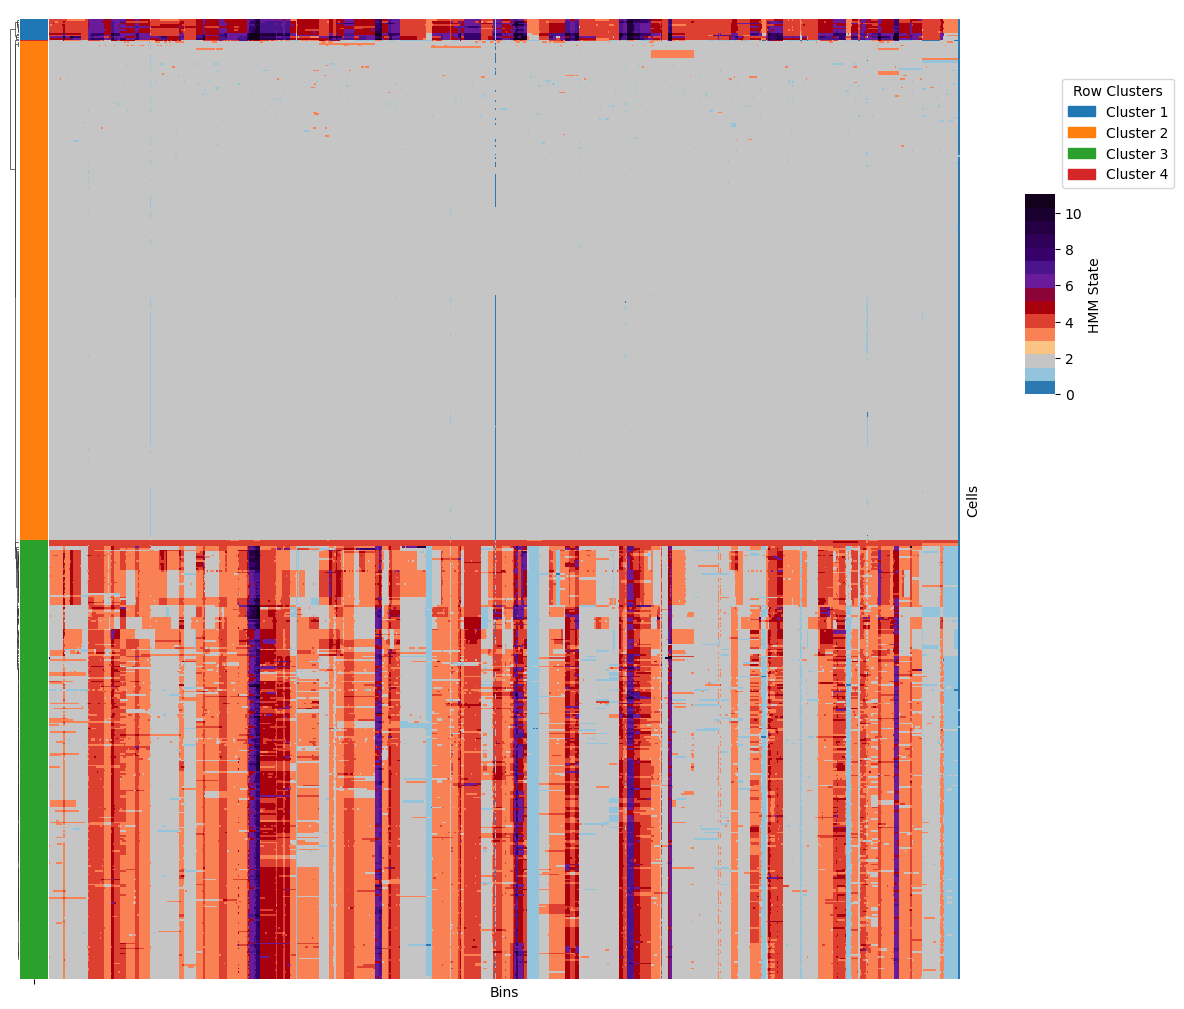

In [73]:
signals_clusters = plot_state_heatmap(signals_matrix, title="HMM Copy States Heatmap for Chromosomes 1 and 2", cluster_t = 4)

[2 3 1 4]
275
(275, 4375)


/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x800 with 0 Axes>

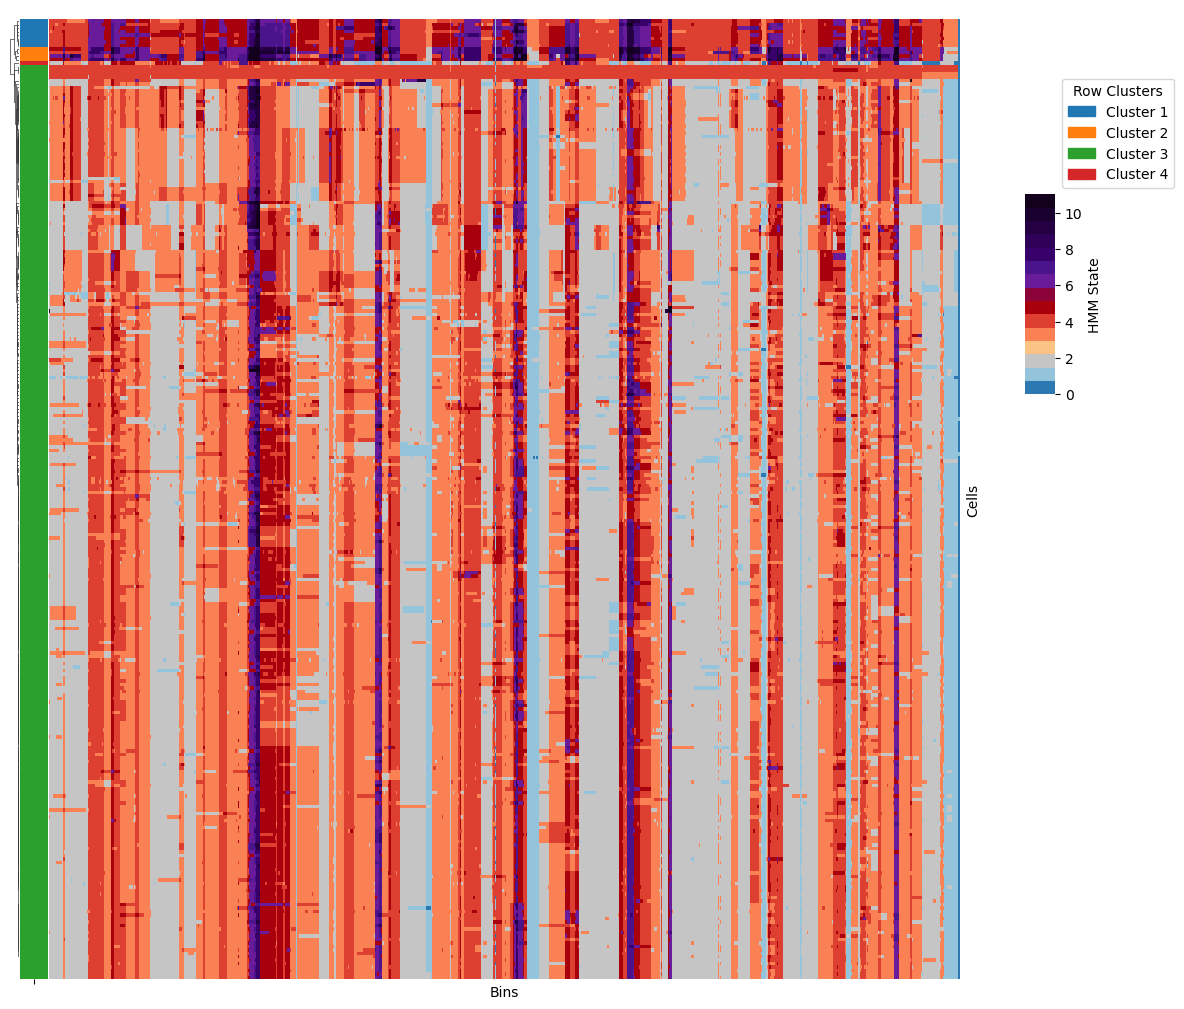

cell_id
A96123A-R21-C09    3
A96123A-R21-C14    3
A96123A-R21-C17    3
A96123A-R21-C22    3
A96123A-R21-C36    3
                  ..
A96167B-R53-C46    1
A96167B-R53-C63    3
A96167B-R54-C30    3
A96167B-R56-C33    3
A96167B-R57-C19    3
Length: 275, dtype: int32

In [74]:
print(signals_clusters.unique())

# Remove normal cells
abnormal_signals_clusters = signals_clusters[signals_clusters != 2]
# Filter matrix to only include abnormal cells
abnormal_cells = signals_clusters.index[signals_clusters != 2]
print(len(abnormal_cells))
abnormal_cells_matrix = signals_matrix.loc[abnormal_cells]
print(abnormal_cells_matrix.shape)

plot_state_heatmap(abnormal_cells_matrix, title="HMM Copy States Heatmap for Abnormal Cells", cluster_t = 4)

In [205]:
# Combining small clusters into one arbitrarily

def safe_mode(x):
    m = mode(x, nan_policy="omit", keepdims=False)

    # m.mode and m.count could be scalars or arrays depending on scipy version and input
    if m.count is not None:
        count_val = m.count if np.isscalar(m.count) else m.count[0]
        if count_val > 0:
            return m.mode if np.isscalar(m.mode) else m.mode[0]

    return np.nan

clusters_df = pd.DataFrame({
    "cell_id": abnormal_cells_matrix.index,
    "cluster": abnormal_signals_clusters
})
clusters_df['cluster'] = clusters_df['cluster'].replace({1: 0, 2: 0, 3: 1, 4: 0})
clusters_df = clusters_df.set_index("cell_id").loc[abnormal_cells_matrix.index]

def get_cnv_profile(state_matrix, cluster_label_df):
    state_matrix_clusters = state_matrix.copy()
    state_matrix_clusters['cluster'] = cluster_label_df['cluster']
    cluster_profiles = (
        state_matrix_clusters.groupby("cluster").agg(safe_mode)
    )
    if "cluster" in cluster_profiles.columns:
        cluster_profiles = cluster_profiles.drop(columns=["cluster"])
    
    cluster_profiles = cluster_profiles.reset_index()

    cell_counts = state_matrix_clusters.groupby("cluster").size()
    cluster_profiles['cell_count'] = cluster_profiles['cluster'].map(cell_counts)
    
    return cluster_profiles

def format_cnv_profile(cluster_profiles, bin_df):
    # Melt to long format
    profile_df = cluster_profiles.melt(id_vars=["cluster", "cell_count"],
                                       var_name="bin_id", value_name="state")

    merged_cluster_profiles_lst = []
    cluster_cell_count_df = cluster_profiles[["cluster", "cell_count"]].drop_duplicates()
    for cluster, cell_count in cluster_cell_count_df.itertuples(index=False):
        cluster_bin_df = bin_df.copy()
        cluster_bin_df["cluster"] = cluster
        cluster_bin_df["cell_count"] = cell_count
        cluster_profile_df = profile_df[profile_df["cluster"] == cluster].drop(columns=["cluster", "cell_count"])
        cluster_merged_profile_df = cluster_profile_df.merge(cluster_bin_df, on = "bin_id", how="right")
        cluster_merged_profile_df["state"] = cluster_merged_profile_df["state"].fillna(0).astype(int)
        merged_cluster_profiles_lst.append(cluster_merged_profile_df)
    merged_profile_df = pd.concat(merged_cluster_profiles_lst, ignore_index=True)

    # Rename and sort
    merged_profile_df = merged_profile_df.rename(columns={"cluster": "clone"})
    merged_profile_df = merged_profile_df.sort_values(by=["clone", "chr", "start"]).reset_index(drop=True)

    # Identify runs of same state and chromosome
    merged_profile_df["state_change"] = (
        (merged_profile_df["state"] != merged_profile_df.groupby("clone")["state"].shift()) |
        (merged_profile_df["chr"] != merged_profile_df.groupby("clone")["chr"].shift())
    ).astype(int)
    merged_profile_df["run_id"] = merged_profile_df.groupby("clone")["state_change"].cumsum()

    # Collapse
    collapsed = merged_profile_df.groupby(["clone", "chr", "run_id", "state", "cell_count"], as_index=False).agg({
        "start": "min",
        "end": "max"
    })

    collapsed["size"] = collapsed["end"] - collapsed["start"]
    collapsed["copy_number"] = collapsed["state"].astype(int) + 2

    final = collapsed[["clone", "chr", "start", "end", "copy_number", "state", "size", "cell_count"]]
    final = final.sort_values(by=["clone", "chr", "start"]).reset_index(drop=True)

    return final






In [169]:
cluster_profiles = get_cnv_profile(abnormal_cells_matrix, clusters_df)
cluster_profiles.head()

,cluster,1:2000001-2500000,1:3000001-3500000,1:4000001-4500000,1:4500001-5000000,1:5000001-5500000,1:5500001-6000000,1:6000001-6500000,1:6500001-7000000,1:7000001-7500000,...,Y:14500001-15000000,Y:16500001-17000000,Y:17000001-17500000,Y:17500001-18000000,Y:18000001-18500000,Y:18500001-19000000,Y:20500001-21000000,Y:21000001-21500000,Y:21500001-22000000,cell_count
0,0,4,4,4,4,4,4,4,4,4,...,0,0,0,0,0,0,0,0,0,13
1,1,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,262


In [206]:
bins_df = pd.read_csv("/data1/shahs3/users/sunge/cnv_simulator/data/refs_2/GRCh37_gcwig_bins.csv")
bins_df['bin_id'] = bins_df['chr'].astype(str) + ":" + bins_df['start'].astype(str) + "-" + bins_df['end'].astype(str)

cnv_profile = format_cnv_profile(cluster_profiles, bins_df)

cnv_profile.head()

,clone,chr,start,end,copy_number,state,size,cell_count
0,0,1,1,2000000,2,0,1999999,13
1,0,1,2000001,2500000,6,4,499999,13
2,0,1,2500001,3000000,2,0,499999,13
3,0,1,3000001,3500000,6,4,499999,13
4,0,1,3500001,4000000,2,0,499999,13


In [208]:
import os

sample_name = "SPECTRUM_OV003"

sample_dir = f"/data1/shahs3/users/sunge/cnv_simulator/synthetic_bams_2/{sample_name}"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
cnv_profile.to_csv(f"{sample_dir}/{sample_name}_cnv_profile.tsv", 
                   sep = "\t", index=False)

/home/sunge/conda_envs/scanpy_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x800 with 0 Axes>

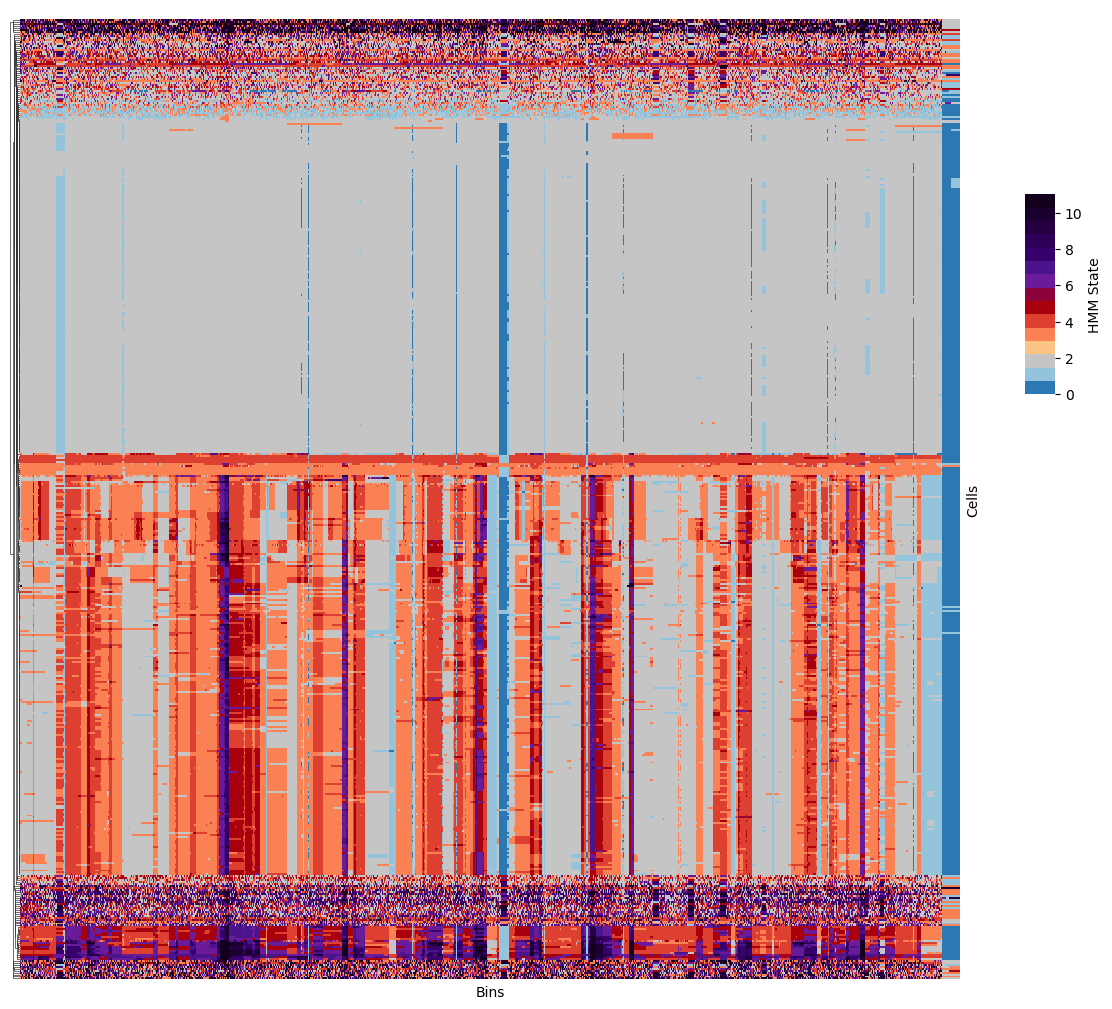

,start,end,chr,reads,gc,map,cor_gc,copy,valid,ideal,modal_curve,modal_quantile,cor_map,multiplier,state,cell_id,fraction_overlapping_reads,is_low_mappability,bin_id
0,1,500000,1,38,0.423964,0.348523,0.121222,0.244838,True,False,313.475617,56.0,NaN,2,2,A96123A-R21-C07,0.000250,True,1:1-500000
1,500001,1000000,1,248,0.501412,0.770391,0.605839,1.223646,True,False,409.349553,56.0,NaN,2,2,A96123A-R21-C07,0.001468,True,1:500001-1000000
2,1000001,1500000,1,410,0.598332,0.982072,0.871019,1.759243,True,False,470.713126,56.0,NaN,2,2,A96123A-R21-C07,0.001206,False,1:1000001-1500000
3,1500001,2000000,1,501,0.539498,0.963004,1.135449,2.293327,True,False,441.234998,56.0,NaN,2,2,A96123A-R21-C07,0.002468,False,1:1500001-2000000
4,2000001,2500000,1,510,0.594508,0.997066,1.086200,2.193856,True,False,469.526759,56.0,NaN,2,2,A96123A-R21-C07,0.001596,False,1:2000001-2500000


In [28]:
hmmcopy_df = pd.read_csv(hmmcopy_path)
hmmcopy_matrix = long_to_cell_bin_matrix(hmmcopy_df, value_col="state")
plot_state_heatmap(hmmcopy_matrix, title="HMM Copy States Heatmap for Chromosomes 1 and 2")

hmmcopy_df.head()
